In [4]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook

import sys
sys.path.append('../Sigma_clip/')
import sigmacut

#from zp_fit import *
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

In [114]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
cks = source_synphot.source.load_source(model_sed_names)

In [5]:
path = '../stellar_spec/pickle/'
from glob import glob
files = glob(path + '*.dat')
files = [x for x in files if (('ukr' not in x) and ('ukw' not in x))]
def Specs(Specs):
    specs = {}
    for spec in Specs:
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs[spec] = model_sed
    return specs
pickle = Specs(files)

Warning, 36 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 42 of 4771 bins contained negative fluxes; they have been set to zero.


In [92]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [25]:
g = 'ps1g'
r = 'ps1r'
i = 'ps1i'
z = 'ps1z'

col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []
# construct color-color vectors
pbg, zpg = pbs[g]
pbr, zpr = pbs[r]
pbi, zpi = pbs[i]
pbz, zpz = pbs[z]
for modelname in pickle:
    model= pickle[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)

    thiscol1 = source_synphot.passband.synphot(model, pbg, zpg)
    thiscol2 = source_synphot.passband.synphot(model, pbr, zpr)
    thiscol3 = source_synphot.passband.synphot(model, pbi, zpi)
    thiscol4 = source_synphot.passband.synphot(model, pbz, zpz)

    col1.append(thiscol1)
    col2.append(thiscol2)
    col3.append(thiscol3)
    col4.append(thiscol4)
col1 = np.array(col1)
col2 = np.array(col2)
col3 = np.array(col3)
col4 = np.array(col4)
# select only useful objects
good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)* ~np.isnan(col4)
good = np.array(good)

syng = col1[good]
synr = col2[good]
syni = col3[good]
synz = col4[good]

models = {'g': syng, 'r':synr, 'i':syni, 'z':synz}

In [170]:
data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
data = data.iloc[(data['ps_score'].values > 0.9) & (data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
data['gMeanPSFMagErr'] = data['gMeanPSFMagErr'].values * (1.005) 
data['rMeanPSFMagErr'] = data['rMeanPSFMagErr'].values * (1.005) 
data['iMeanPSFMagErr'] = data['iMeanPSFMagErr'].values * (1.005) 
data['zMeanPSFMagErr'] = data['zMeanPSFMagErr'].values * (1.005) 

kb = -2.5*np.log10(data['PDC'].values) # why divide by 100?
kbe = 0.434 * np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)

In [171]:
data.campaign.unique()

array([11,  7,  2, 15,  3,  6, 17, 12,  1,  8, 14, 18,  5,  4, 16, 13,  0])

In [163]:
def Plotter(K,Colours,Compare,Channel,fitfilt='', Residuals = False, Close = True):
    Params = Parms_dict(K)
    plt.figure()#figsize=(10,6))
    #plt.suptitle('Channel ' + str(Channel) + ', Zp = ' + str(np.round(K[0],3)) + 
     #            '\n' + 'Ak ={}, Ag = {}, Ar = {}, Ai ={}'.format(np.round(Params['Ak'],3),
     #                                                             np.round(Params['Ag'],3),
     #                                                             np.round(Params['Ar'],3),
     #                                                             np.round(Params['Ai'],3)))
    for i in range(len(Compare)):
        X,Y = Compare[i]
        kob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours,fitfilt)

        ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]
        ob_x = ob_x[:,ind]
        ob_y = ob_y[:,ind]
        
        
        #plt.subplot(2,2,i+1)
        plt.xlabel(X)
        plt.ylabel(Y)
        if i == 2:
            if Residuals:
                dist = Dist_tensor(X,Y,Params,Colours,fitfilt,Tensor = True)
                
                plt.errorbar(ob_x[0,:],dist,ob_y[1,:],fmt='.',alpha=0.4,label='Observed')
                plt.axhline(0,ls='--',color='k',label='Model')
                plt.legend(loc='upper center', bbox_to_anchor=(1.5, .5))
                plt.ylim(-.6, .6)
            else:
                plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4,label='Observed')
                plt.plot(locus[0,:],locus[1,:],label='Model')
                plt.legend(loc='upper center', bbox_to_anchor=(1.5, .5))
                plt.xlim(0.2, .9)
                #plt.ylim(-.5, 1)
        else:
            if Residuals:
                dist = Dist_tensor(X,Y,Params,Colours,fitfilt,Tensor = True)
                plt.axhline(0,ls='--',color='k',label='offset = {}'.format(np.round(K[0],4)))
                plt.errorbar(ob_x[0,:],dist,ob_y[1,:],fmt='.',alpha=0.4)
                plt.legend()
                plt.ylabel(r'('+ Y +')obs - (' + Y + ')syn')
                #plt.hist(dist.flatten(),bins=100)
                #plt.ylim(-.6, .6)
            else:
                plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4)
                plt.plot(locus[0,:],locus[1,:])
                #plt.xlim(-0.5, 1)
                plt.xlim(0.2, .9)
                #plt.ylim(-.5, 1)
    plt.subplots_adjust(wspace=.25,hspace=.2)
    if Residuals:
        plt.savefig('./figs/fit_i/'+ fitfilt + '_fit_' + Y + '_residual'+ '_camp' + str(Channel) +'.png')
    else:
        plt.savefig('./figs/fit_i/'+ fitfilt + Y + '_camp' + str(Channel) + '.png')
    if Close:
        plt.close()
    
def Dot_prod_error(x,y,Model):
    """
    Calculate the error projection in the direction of a selected point.
    """
    #print(Model.shape)
    adj = y[0,:] - Model[1,:]
    op = x[0,:] - Model[0,:]
    #print(adj.shape,op.shape)
    hyp = np.sqrt(adj**2 + op**2)
    costheta = adj / hyp
    yerr_proj = abs(y[1,:] * costheta)
    xerr_proj = abs(x[1,:] * costheta)
    
    proj_err = yerr_proj + xerr_proj
    #print(proj_err)
    return proj_err    

def Calculate_distance(data,trend):
    x = np.zeros((data.shape[1],trend.shape[1])) + data[0,:,np.newaxis]
    x -= trend[0,np.newaxis,:]
    y = np.zeros((data.shape[1],trend.shape[1])) + data[1,:,np.newaxis]
    y -= trend[1,np.newaxis,:]

    dist = np.sqrt(x**2 + y**2)

    minind = np.nanargmin(abs(dist),axis=1)
    #proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
    mindist = np.nanmin(abs(dist),axis=1)
    sign = (data[1,:] - trend[1,minind])
    sign = sign / abs(sign)

    resid = mindist * sign
    return resid

def Dist_tensor(X,Y,Params,Colours,fitfilt='',Tensor=False,Plot = False):
    ob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours,fitfilt)
    
    #ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]
    #ob_x = ob_x[:,ind]
    #ob_y = ob_y[:,ind]
    
    
    if Plot:
        plt.figure()
        plt.title(X + ' ' + Y)
        plt.plot(ob_x[0,:],ob_y[0,:],'.')
        plt.plot(locus[0,:],locus[1,:])
    #print(ob_x.shape)
    #print('x ',ob_x.shape[1])
    x = np.zeros((ob_x.shape[1],locus.shape[1])) + ob_x[0,:,np.newaxis]
    x -= locus[0,np.newaxis,:]
    y = np.zeros((ob_y.shape[1],locus.shape[1])) + ob_y[0,:,np.newaxis]
    y -= locus[1,np.newaxis,:]

    dist_tensor = np.sqrt(x**2 + y**2)
    #print(np.nanmin(dist_tensor,axis=1))
    #print(X + Y +' dist ',dist_tensor.shape)
    if len(dist_tensor) > 0:
        minind = np.nanargmin(abs(dist_tensor),axis=1)
        mindist = np.nanmin(abs(dist_tensor),axis=1)
        sign = (ob_y[0,:] - locus[1,minind])
        sign = sign / abs(sign)

        eh = mindist * sign
    
        proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
        #print('mindist ',mindist)
        if Tensor:
            return eh
        if len(mindist) > 0:
            #print('thingo',np.nanstd(mindist))
            residual = np.nansum(abs(mindist)) #/ proj_err)
        else:
            #print('infs')
            residual = np.inf
    else:
        if Tensor:
            return []
        residual = np.inf
        #residual += 100*np.sum(np.isnan(dist))
    #print(residual)
    cut_points = len(indo) - len(ind)
    return residual + cut_points * 100



import copy
def Get_lcs(X,Y,Params,Colours,fitfilt = ''):
    keys = np.array(list(Colours.keys()))

    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]

    x_interp = np.arange(np.nanmin(x),0.9,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x,y])

    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 

    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == fitfilt: ob_x[0,:] += Params['fitzp']
    if c2 == fitfilt: ob_x[0,:] -= Params['fitzp']


    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == fitfilt: ob_y[0,:] += Params['fitzp']
    if c4 == fitfilt: ob_y[0,:] -= Params['fitzp']
    return ob_x, ob_y, locus

def sigma_mask(data,error= None,sigma=3,Verbose= False):
    if type(error) == type(None):
        error = np.zeros(len(data))
    
    calcaverage = sigmacut.calcaverageclass()
    calcaverage.calcaverage_sigmacutloop(data,verbose=2,Nsigma=sigma
                                         ,median_firstiteration=True,saveused=True)
    if Verbose:
        print("mean:%f (uncertainty:%f)" % (calcaverage.mean,calcaverage.mean_err))
    return calcaverage.clipped


def Cut_data(K,Colours,Compare,fitfilt = '',Plot=False):
    Params = Parms_dict(K)
    c_cut = copy.deepcopy(Colours)
    keys = list(c_cut.keys())
    for X,Y in Compare:
        #X = 'g-r'
        #Y = 'i-z'
        dist = Dist_tensor(X,Y,Params,Colours,fitfilt,True)
        if len(dist) > 0:

            ob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours,fitfilt)
            ob_x2, ob_y2, locus = Get_lcs(X,Y,Params,Colours,fitfilt)
            ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]

            #if X == 'g-r':
            #    ind = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= 0.2) & (ob_y[1,:] < 0.5))[0]
            #elif X == 'r-i':
            #    ind = np.where((ob_x[0,:] <= .6) & (ob_x[0,:] >= 0) & (ob_y[1,:] < 0.5))[0]
            #ob_x = ob_x[:,ind]
            #ob_y = ob_y[:,ind]


            #bad = []
            #print(type(dist))
            #print('std',np.nanstd(dist.flatten()))
            dist = dist.flatten()
            finiteinds = np.where(np.isfinite(dist))[0]
            #dist[~np.isfinite(dist)] = np.nan
            bad = sigma_mask(dist,error=ob_y[:,1],sigma=3)
            bad = finiteinds[bad]
            #for i in range(len(dist)):
                #print(dist[i],ob_y[1,i])
             #   if abs(dist[i]) > 1:
                    #print(dist,ob_y[0,i])
              #      bad += [i]
              #  if abs(dist[i]) > 10*ob_y[1,i]:

               #     bad += [i]
            if Plot:
                plt.figure()
                plt.errorbar(ob_x2[0,:],ob_y2[0,:],yerr = ob_y2[1,:],fmt='.')
                plt.errorbar(locus[0,:],locus[1,:])
                #plt.errorbar(ob_x[0,bad],ob_y[0,bad],yerr = ob_y[1,bad],fmt='.')
                plt.errorbar(ob_x2[0,ind[bad]],ob_y2[0,ind[bad]],yerr = ob_y2[1,ind[bad]],fmt='r.')
                #plt.xlim(.5,0.9)

            for key in keys:
                if 'obs' in key:
                    #print(dist[bad],6*c_cut[key][1, main_ind[bad]])
                    c_cut[key][:, ind[bad]] = np.nan
                    #print('killed ', key)
            #print(colours[keys[xind][0]][:, main_ind[bad]])
    return ind[bad]

def Parms_dict(K):
    #num = len(K)
    num = 0
    k =np.zeros(6)
    if num ==1:
        k[0] = K[0]
        k[1:] = 0
        
    elif num == 6:
        k = K
    Params = {}
    Params['fitzp'] = 0#k[0]
    Params['Ak'] = 0#k[1]
    Params['Ag'] = 0#k[2]
    Params['Ar'] = 0#k[3]
    Params['Ai'] = 0#k[4]
    Params['Az'] = 0#k[5]
    
    return Params

def Make_colours(Data, Model, Compare, Extinction = 0):
    R = {'g': 3.518, 'r':2.617, 'i':1.971, 'z':1.549}
    colours = {}
    for x,y in Compare:
        colours['obs ' + x] = np.array([Data[x.split('-')[0]+'MeanPSFMag'].values - Data[x.split('-')[1]+'MeanPSFMag'].values,
                                        Data[x.split('-')[0]+'MeanPSFMagErr'].values - Data[x.split('-')[1]+'MeanPSFMagErr'].values])
        colours['obs ' + y] = np.array([Data[y.split('-')[0]+'MeanPSFMag'].values - Data[y.split('-')[1]+'MeanPSFMag'].values,
                                        Data[y.split('-')[0]+'MeanPSFMagErr'].values - Data[y.split('-')[1]+'MeanPSFMagErr'].values])
        colours['mod ' + x] = Model[:,0]#Model[x.split('-')[0]] - Model[x.split('-')[1]]
        colours['mod ' + y] = Model[:,1] #Model[y.split('-')[0]] - Model[y.split('-')[1]]
        
        if Extinction > 0:
            colours['obs ' + x] -= Extinction*((R[x.split('-')[0]] - R[x.split('-')[1]]))
            colours['obs ' + y] -= Extinction*(R[y.split('-')[0]] - R[y.split('-')[1]])
    return colours 

def SLR_fit_multi(K,Data,Model,Compare,fitfilt='',Plot = False):
    #print('guess ', K)
    params = Parms_dict(K)
    Colours = Make_colours(Data,Model,Compare,Extinction = K)
    #Colours = Cut_data(K,Colours,Compare)
    res = 0
    #print(K)
    for x,y in Compare:
        residual = Dist_tensor(x,y,params,Colours,fitfilt,Tensor=True,Plot=Plot)
        if len(residual)>0:
            res += np.nansum(abs(residual))
        else:
            res = np.inf
    #print('residual ', res)
    return res
    

In [198]:
(1.971 - 1.549) * 0.15

0.06330000000000002

In [177]:
(3.518 - 2.617) * 0.0353

0.03180529999999999

In [22]:
data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
#data = data.iloc[(data['ps_score'].values > 0.95) & (data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
data['gMeanPSFMagErr'] = data['gMeanPSFMagErr'].values * (1.005) 
data['rMeanPSFMagErr'] = data['rMeanPSFMagErr'].values * (1.005) 
data['iMeanPSFMagErr'] = data['iMeanPSFMagErr'].values * (1.005) 
data['zMeanPSFMagErr'] = data['zMeanPSFMagErr'].values * (1.005) 

kb = -2.5*np.log10(data['PDC'].values/100) # why divide by 100?
kbe = 0.434 * np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)
cind =  ((data['campaign'].values == 16)) #& (data['Channel'].values == 1)

dat = data.iloc[cind]

In [190]:
compare = np.array([['r-i','g-r'],['r-i','i-z']])#,['g-r','g-i'],['g-r','r-z'],['g-r','g-z']])

In [237]:
cind =  ((data['campaign'].values == 16)) #& (data['Channel'].values == 1)
dat = data.iloc[cind]
colours16_c = Make_colours(dat,tonry,compare,Extinction = 0.0353)#0.0158)
colours16 = Make_colours(dat,tonry,compare,Extinction = 0)#0.0158)

cind =  ((data['campaign'].values == 15)) #& (data['Channel'].values == 1)
dat = data.iloc[cind]
colours15_c = Make_colours(dat,tonry,compare,Extinction = 0.1592)#0.0158)
colours15 = Make_colours(dat,tonry,compare,Extinction = 0)#0.0158)


cind =  ((data['campaign'].values == 19)) #& (data['Channel'].values == 1)
dat = data.iloc[cind]
colours19_c = Make_colours(dat,tonry,compare,Extinction = 0.0703)#0.0158)
colours19 = Make_colours(dat,tonry,compare,Extinction = 0)#0.0158)

In [26]:
tonry = np.loadtxt('Tonry_splines.txt')

In [179]:
colours['mod g-r'] = tonry[:,1]
colours['mod r-i'] = tonry[:,0]

In [82]:
colours['obs r-i'].shape

(2, 14255)

In [132]:
Params = Parms_dict(0)
c_cut = copy.deepcopy(colours)
keys = list(c_cut.keys())

X = 'r-i'
Y = 'g-r'
dist = Dist_tensor(X,Y,Params,colours,'',True)

In [84]:
test = Calculate_distance(),tonry)

In [54]:
True + False

1

In [56]:
np.array([True,True]) & np.array([True,False])

array([ True, False])

In [164]:
def Tonry_clip(Colours):
    """
    Use the Tonry 2012 PS1 splines to sigma clip the observed data.
    """
    tonry = np.loadtxt('Tonry_splines.txt')
    X = 'r-i'
    Y = 'g-r'
    x = Colours['obs ' + X][0,:]
    mx = tonry[:,0]
    y = Colours['obs ' + Y][0,:]
    my = tonry[:,1]
    # set up distance matrix
    xx = x[:,np.newaxis] - mx[np.newaxis,:]
    yy = y[:,np.newaxis] - my[np.newaxis,:]
    # calculate distance
    dd = np.sqrt(xx**2 + yy**2)
    # return min values for the observation axis
    mins = np.nanmin(dd,axis=1)
    # Sigma clip the distance data
    sig = sigma_mask(mins)
    # return sigma clipped mask
    return ~sig

def Tonry_residual(Colours):
    """
    Calculate the residuals of the observed data from the Tonry et al 2012 PS1 splines.
    """
    tonry = np.loadtxt('Tonry_splines.txt')
    X = 'r-i'
    Y = 'g-r'
    x = Colours['obs ' + X][0,:]
    mx = tonry[:,0]
    y = Colours['obs ' + Y][0,:]
    my = tonry[:,1]
    # set up distance matrix
    xx = x[:,np.newaxis] - mx[np.newaxis,:]
    yy = y[:,np.newaxis] - my[np.newaxis,:]
    # calculate distance
    dd = np.sqrt(xx**2 + yy**2)
    # return min values for the observation axis
    mingr = np.nanmin(dd,axis=1)
    return np.nansum(mingr) #+ np.nansum(miniz)

def Tonry_fit(K,Data,Model,Compare):
    """
    Wrapper for the residuals function
    """
    print(K)
    Colours = Make_colours(Data,Model,Compare,Extinction = K)
    res = Tonry_residual(Colours)
    return res

def Tonry_reduce(Data,Camp):
    '''
    Uses the Tonry et al. 2012 PS1 splines to fit dust and find all outliers.
    '''
    data = copy.deepcopy(Data)
    tonry = np.loadtxt('Tonry_splines.txt')
    compare = np.array([['r-i','g-r'],['r-i','i-z']])      
    cind =  ((data['campaign'].values == Camp))
    dat = data.iloc[cind]
    clips = []
    for i in range(2):
        if i == 0:
            k0 = 0
        else:
            k0 = res.x
        res = minimize(Tonry_fit,k0,args=(dat,tonry,compare),method='Nelder-Mead')
        
        colours = Make_colours(dat,tonry,compare,Extinction = res.x)
        clip = Tonry_clip(colours)
        clips += [clip]
        dat = dat.iloc[clip]
        print('Pass ' + str(i+1) + ': '  + str(np.round(res.x[0],4)))
    clips[0][clips[0]] = clips[1]
    return res.x, clips[0]

In [ ]:
Rocolours16_c

In [221]:
test = Tonry_clip(colours16_c)

i:00 mean:0.023426(0.000924) stdev:0.096609(0.000653) Nchanged:0 Nused:10942 Nskipped:0
i:01 mean:0.037323(0.000452) stdev:0.046838(0.000320) Nchanged:218 Nused:10724 Nskipped:218
i:02 mean:0.031005(0.000300) stdev:0.030553(0.000212) Nchanged:333 Nused:10391 Nskipped:551
i:03 mean:0.028157(0.000245) stdev:0.024666(0.000173) Nchanged:247 Nused:10144 Nskipped:798
i:04 mean:0.026567(0.000220) stdev:0.021990(0.000156) Nchanged:189 Nused:9955 Nskipped:987
i:05 mean:0.025626(0.000207) stdev:0.020557(0.000147) Nchanged:131 Nused:9824 Nskipped:1118
i:06 mean:0.025010(0.000199) stdev:0.019659(0.000141) Nchanged:93 Nused:9731 Nskipped:1211
i:07 mean:0.024582(0.000194) stdev:0.019054(0.000137) Nchanged:68 Nused:9663 Nskipped:1279
i:08 mean:0.024323(0.000191) stdev:0.018695(0.000135) Nchanged:43 Nused:9620 Nskipped:1322
i:09 mean:0.024175(0.000189) stdev:0.018493(0.000133) Nchanged:25 Nused:9595 Nskipped:1347
mean:0.024175 (uncertainty:0.000189)


In [227]:
colours2['obs r-i'][:,test]

array([[-0.77610016,  1.32080078,  0.1855011 , ..., -0.05709839,
         0.32879829,  0.08540154],
       [-0.01613527,  0.00553855, -0.01348308, ..., -0.0215462 ,
         0.02359237, -0.0031758 ]])

In [240]:
clip16_c = Tonry_clip(colours16_c)
clip16 = Tonry_clip(colours16)

clip15_c = Tonry_clip(colours15_c)
clip15 = Tonry_clip(colours15)

clip19_c = Tonry_clip(colours19_c)
clip19 = Tonry_clip(colours19)

i:00 mean:0.023426(0.000924) stdev:0.096609(0.000653) Nchanged:0 Nused:10942 Nskipped:0
i:01 mean:0.037323(0.000452) stdev:0.046838(0.000320) Nchanged:218 Nused:10724 Nskipped:218
i:02 mean:0.031005(0.000300) stdev:0.030553(0.000212) Nchanged:333 Nused:10391 Nskipped:551
i:03 mean:0.028157(0.000245) stdev:0.024666(0.000173) Nchanged:247 Nused:10144 Nskipped:798
i:04 mean:0.026567(0.000220) stdev:0.021990(0.000156) Nchanged:189 Nused:9955 Nskipped:987
i:05 mean:0.025626(0.000207) stdev:0.020557(0.000147) Nchanged:131 Nused:9824 Nskipped:1118
i:06 mean:0.025010(0.000199) stdev:0.019659(0.000141) Nchanged:93 Nused:9731 Nskipped:1211
i:07 mean:0.024582(0.000194) stdev:0.019054(0.000137) Nchanged:68 Nused:9663 Nskipped:1279
i:08 mean:0.024323(0.000191) stdev:0.018695(0.000135) Nchanged:43 Nused:9620 Nskipped:1322
i:09 mean:0.024175(0.000189) stdev:0.018493(0.000133) Nchanged:25 Nused:9595 Nskipped:1347
mean:0.024175 (uncertainty:0.000189)
i:00 mean:0.022903(0.000923) stdev:0.096580(0.000653

<IPython.core.display.Javascript object>


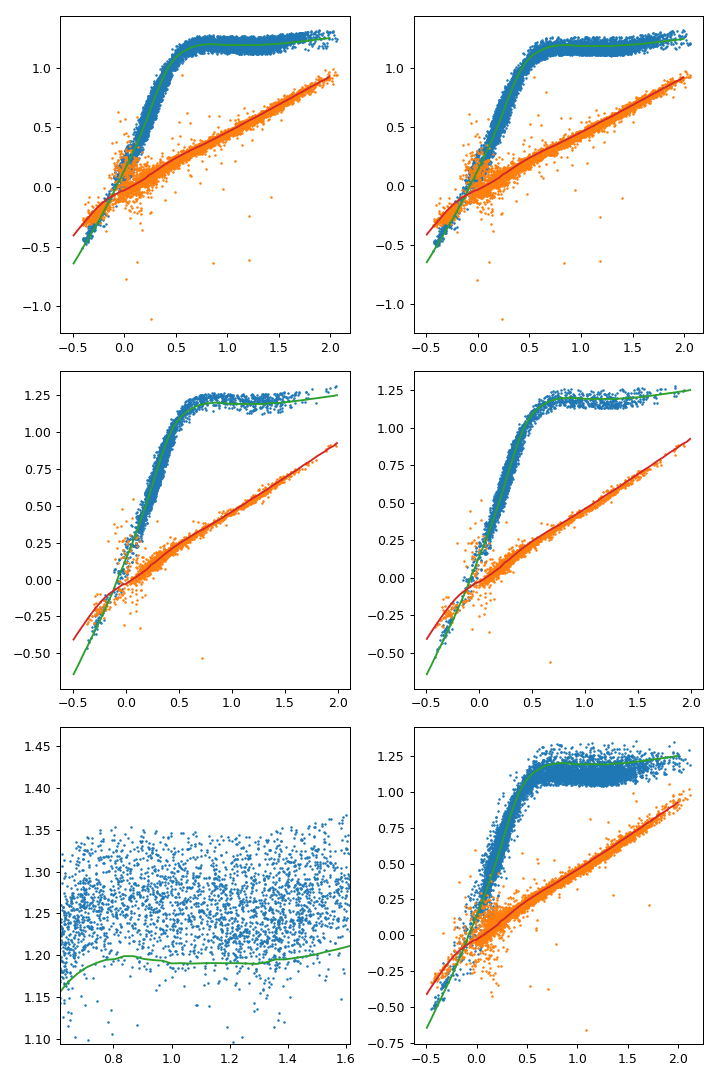

In [245]:
plt.figure(figsize=(8,12))
#plt.plot(colours['obs r-i'][0,:],colours['obs g-r'][0,:],'k.',ms=2)
plt.subplot(3,2,1)
plt.plot(colours16['obs r-i'][0,clip16],colours16['obs g-r'][0,clip16],'.',ms=2)
plt.plot(colours16['obs r-i'][0,clip16],colours16['obs i-z'][0,clip16],'.',ms=2)
#plt.plot(colours['obs r-i'][0,~clip],colours['obs i-z'][0,~clip],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')
plt.subplot(3,2,2)
plt.plot(colours16_c['obs r-i'][0,clip16_c],colours16_c['obs g-r'][0,clip16_c],'.',ms=2)
plt.plot(colours16_c['obs r-i'][0,clip16_c],colours16_c['obs i-z'][0,clip16_c],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')

plt.subplot(3,2,3)
plt.plot(colours19['obs r-i'][0,clip19],colours19['obs g-r'][0,clip19],'.',ms=2)
plt.plot(colours19['obs r-i'][0,clip19],colours19['obs i-z'][0,clip19],'.',ms=2)
#plt.plot(colours['obs r-i'][0,~clip],colours['obs i-z'][0,~clip],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')
plt.subplot(3,2,4)
plt.plot(colours19_c['obs r-i'][0,clip19_c],colours19_c['obs g-r'][0,clip19_c],'.',ms=2)
plt.plot(colours19_c['obs r-i'][0,clip19_c],colours19_c['obs i-z'][0,clip19_c],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')

plt.subplot(3,2,5)
plt.plot(colours15['obs r-i'][0,clip15],colours15['obs g-r'][0,clip15],'.',ms=2)
plt.plot(colours15['obs r-i'][0,clip15],colours15['obs i-z'][0,clip15],'.',ms=2)
#plt.plot(colours['obs r-i'][0,~clip],colours['obs i-z'][0,~clip],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')
plt.subplot(3,2,6)
plt.plot(colours15_c['obs r-i'][0,clip15_c],colours15_c['obs g-r'][0,clip15_c],'.',ms=2)
plt.plot(colours15_c['obs r-i'][0,clip15_c],colours15_c['obs i-z'][0,clip15_c],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')

#plt.plot(colours['mod r-i']+0.07854226,colours['mod g-r'] + 0.10432243,'.')
#plt.plot(colours['mod r-i'],colours['mod g-r'],'.')
plt.tight_layout()

In [31]:
compare = np.array([['r-i','g-r']])#,['r-i','i-z']])
k0 = 0
cind =  ((data['campaign'].values == 10)) #& (data['Channel'].values == 1)
dat = data.iloc[cind]
res = minimize(Tonry_fit,k0,args=(dat,tonry,compare),method='Nelder-Mead')
print(res)

 final_simplex: (array([[0.01590625],
       [0.0159375 ]]), array([436.29183729, 436.29184208]))
           fun: 436.2918372946516
       message: 'Optimization terminated successfully.'
          nfev: 28
           nit: 14
        status: 0
       success: True
             x: array([0.01590625])


In [158]:
compare = np.array([['r-i','g-r']])#,['r-i','i-z']])
k0 = 0
cind =  ((data['campaign'].values == 15)) #& (data['Channel'].values == 1)
dat = data.iloc[cind]
res = minimize(Tonry_fit,k0,args=(dat,tonry,compare),method='Nelder-Mead')
print(res)

KeyboardInterrupt: 

In [60]:
def Tonry_reduce(Data,Camp):
    data = copy.deepcopy(Data)
    tonry = np.loadtxt('Tonry_splines.txt')
    compare = np.array([['r-i','g-r'],['r-i','i-z']])      
    cind =  ((data['campaign'].values == Camp))
    dat = data.iloc[cind]
    clips = []
    for i in range(2):
        if i == 0:
            k0 = 0
        else:
            k0 = res.x
        res = minimize(Tonry_fit,k0,args=(dat,tonry,compare),method='Nelder-Mead')
        
        colours = Make_colours(dat,tonry,compare,Extinction = res.x)
        clip = Tonry_clip(colours)
        clips += [clip]
        dat = dat.iloc[clip]
        print('Pass ' + str(i+1) + ': '  + str(np.round(res.x[0],4)))
    clips[0][clips[0]] = clips[1]
    return res.x, clips[0]

In [169]:
ex, clips = Tonry_reduce(data,10)

[0.]
[0.00025]
[0.0005]
[0.00075]
[0.00125]
[0.00175]
[0.00275]
[0.00375]
[0.00575]
[0.00775]
[0.01175]
[0.01575]
[0.02375]
[0.01175]
[0.01975]
[0.01375]
[0.01775]
[0.01675]
[0.01475]
[0.01625]
[0.01525]
[0.016]
[0.01625]
[0.015875]
[0.01575]
[0.0159375]
[0.016]
[0.01590625]
i:00 mean:0.018861(0.000511) stdev:0.060981(0.000361) Nchanged:0 Nused:14255 Nskipped:0
i:01 mean:0.025004(0.000216) stdev:0.025577(0.000153) Nchanged:232 Nused:14023 Nskipped:232
i:02 mean:0.022503(0.000160) stdev:0.018754(0.000113) Nchanged:293 Nused:13730 Nskipped:525
i:03 mean:0.021321(0.000143) stdev:0.016644(0.000101) Nchanged:239 Nused:13491 Nskipped:764
i:04 mean:0.020773(0.000137) stdev:0.015816(0.000097) Nchanged:137 Nused:13354 Nskipped:901
i:05 mean:0.020528(0.000134) stdev:0.015469(0.000095) Nchanged:66 Nused:13288 Nskipped:967
i:06 mean:0.020407(0.000133) stdev:0.015303(0.000094) Nchanged:34 Nused:13254 Nskipped:1001
i:07 mean:0.020341(0.000132) stdev:0.015214(0.000094) Nchanged:19 Nused:13235 Nskippe

In [165]:
ex, clips = Tonry_reduce(data,15)

[0.]
[0.00025]
[0.0005]
[0.00075]
[0.00125]
[0.00175]
[0.00275]
[0.00375]
[0.00575]
[0.00775]
[0.01175]
[0.01575]
[0.02375]
[0.03175]
[0.04775]
[0.06375]
[0.09575]
[0.12775]
[0.12775]
[0.07975]
[0.11175]
[0.08775]
[0.07975]
[0.09175]
[0.08375]
[0.08975]
[0.09175]
[0.08875]
[0.08775]
[0.08925]
[0.08975]
[0.089]
[0.08875]
[0.089125]
[0.088875]
[0.0890625]
i:00 mean:0.024524(0.000871) stdev:0.078524(0.000616) Nchanged:0 Nused:8121 Nskipped:0
i:01 mean:0.035053(0.000422) stdev:0.037664(0.000298) Nchanged:149 Nused:7972 Nskipped:149
i:02 mean:0.030908(0.000313) stdev:0.027599(0.000221) Nchanged:205 Nused:7767 Nskipped:354
i:03 mean:0.028807(0.000272) stdev:0.023750(0.000193) Nchanged:162 Nused:7605 Nskipped:516
i:04 mean:0.027636(0.000253) stdev:0.021910(0.000179) Nchanged:113 Nused:7492 Nskipped:629
i:05 mean:0.027060(0.000244) stdev:0.021069(0.000173) Nchanged:62 Nused:7430 Nskipped:691
i:06 mean:0.026779(0.000240) stdev:0.020677(0.000170) Nchanged:32 Nused:7398 Nskipped:723
i:07 mean:0.0

In [167]:
dat = data.iloc[data['campaign'].values == 1]

<IPython.core.display.Javascript object>


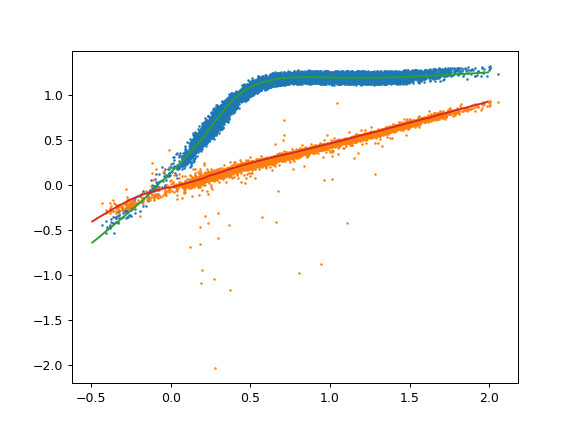

In [168]:
compare = np.array([['r-i','g-r'],['r-i','i-z']])
colours = Make_colours(dat.iloc[clips],tonry,compare,Extinction = ex)
plt.figure()
plt.plot(colours['obs r-i'][0],colours['obs g-r'][0],'.',ms=2)
plt.plot(colours['obs r-i'][0],colours['obs i-z'][0],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')

## ex

In [279]:
compare = np.array([['r-i','g-r'],['r-i','i-z']])
colours = Make_colours(dat,tonry,compare,res.x)
clip = Tonry_clip(colours)
colours2 = Make_colours(dat,tonry,compare,0)
clip2 = Tonry_clip(colours)

coloursdust = Make_colours(dat,tonry,compare,0.015)
clipdust = Tonry_clip(coloursdust)

i:00 mean:0.018861(0.000511) stdev:0.060981(0.000361) Nchanged:0 Nused:14255 Nskipped:0
i:01 mean:0.025004(0.000216) stdev:0.025577(0.000153) Nchanged:232 Nused:14023 Nskipped:232
i:02 mean:0.022503(0.000160) stdev:0.018754(0.000113) Nchanged:293 Nused:13730 Nskipped:525
i:03 mean:0.021321(0.000143) stdev:0.016644(0.000101) Nchanged:239 Nused:13491 Nskipped:764
i:04 mean:0.020773(0.000137) stdev:0.015816(0.000097) Nchanged:137 Nused:13354 Nskipped:901
i:05 mean:0.020528(0.000134) stdev:0.015469(0.000095) Nchanged:66 Nused:13288 Nskipped:967
i:06 mean:0.020407(0.000133) stdev:0.015303(0.000094) Nchanged:34 Nused:13254 Nskipped:1001
i:07 mean:0.020341(0.000132) stdev:0.015214(0.000094) Nchanged:19 Nused:13235 Nskipped:1020
i:08 mean:0.020317(0.000132) stdev:0.015181(0.000093) Nchanged:7 Nused:13228 Nskipped:1027
i:09 mean:0.020296(0.000132) stdev:0.015153(0.000093) Nchanged:6 Nused:13222 Nskipped:1033
mean:0.020296 (uncertainty:0.000132)
i:00 mean:0.018861(0.000511) stdev:0.060981(0.0003

<IPython.core.display.Javascript object>


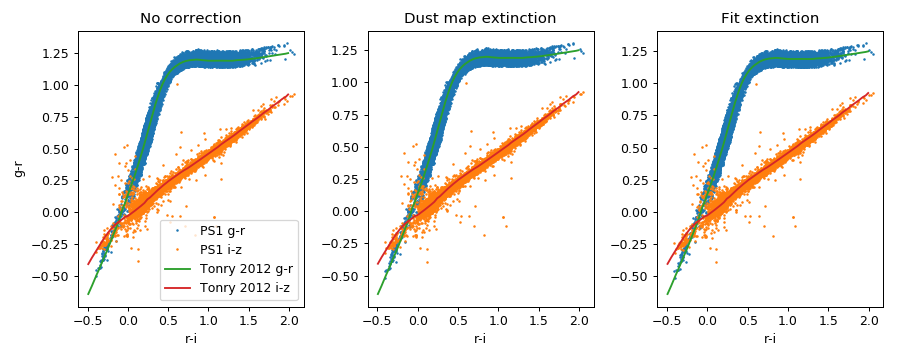

In [280]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title('No correction')
plt.plot(colours2['obs r-i'][0,clip2],colours2['obs g-r'][0,clip2],'.',ms=2,label = 'PS1 g-r')
plt.plot(colours2['obs r-i'][0,clip2],colours2['obs i-z'][0,clip2],'.',ms=2,label = 'PS1 i-z')
#plt.plot(colours['obs r-i'][0,~clip],colours['obs i-z'][0,~clip],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-',label='Tonry 2012 g-r')
plt.plot(tonry[:,0],tonry[:,2],'-',label='Tonry 2012 i-z')
plt.ylabel('g-r')
plt.xlabel('r-i')

plt.legend()

plt.subplot(1,3,2)
plt.title('Dust map extinction')
plt.plot(coloursdust['obs r-i'][0,clipdust],coloursdust['obs g-r'][0,clipdust],'.',ms=2)
plt.plot(coloursdust['obs r-i'][0,clipdust],coloursdust['obs i-z'][0,clipdust],'.',ms=2)
#plt.plot(colours['obs r-i'][0,~clip],colours['obs i-z'][0,~clip],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')
plt.xlabel('r-i')


plt.subplot(1,3,3)
plt.title('Fit extinction')
#plt.plot(colours['obs r-i'][0,:],colours['obs g-r'][0,:],'.',ms=2)
#plt.plot(colours['obs r-i'][0,:],colours['obs i-z'][0,:],'.',ms=2)
plt.plot(colours['obs r-i'][0,clip],colours['obs g-r'][0,clip],'.',ms=2)
plt.plot(colours['obs r-i'][0,clip],colours['obs i-z'][0,clip],'.',ms=2)
#plt.plot(colours['obs r-i'][0,~clip],colours['obs i-z'][0,~clip],'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')
plt.xlabel('r-i')

plt.tight_layout()

plt.savefig('')

# extinction application

In [1]:
from extinction import fm07, apply

In [120]:
spec = pickle['../stellar_spec/pickle/ukb3v.dat']

In [146]:
a_v = 0.981 * ex * (3.518 - 2.617)
test = apply(fm07(spec.wave,a_v),spec.flux)

<IPython.core.display.Javascript object>


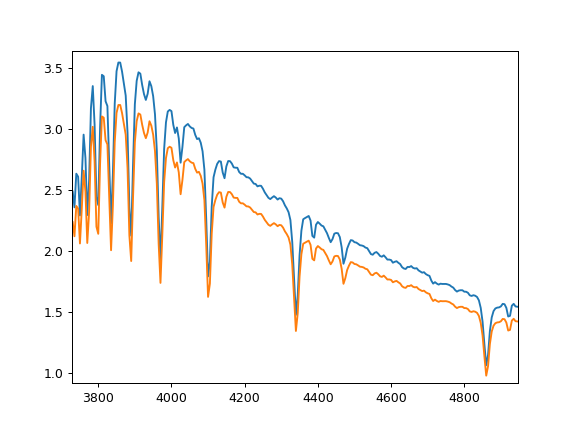

In [147]:
plt.figure()
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,test)

In [148]:
test = Spec_mags(pickle,pbs,a_v)

<IPython.core.display.Javascript object>


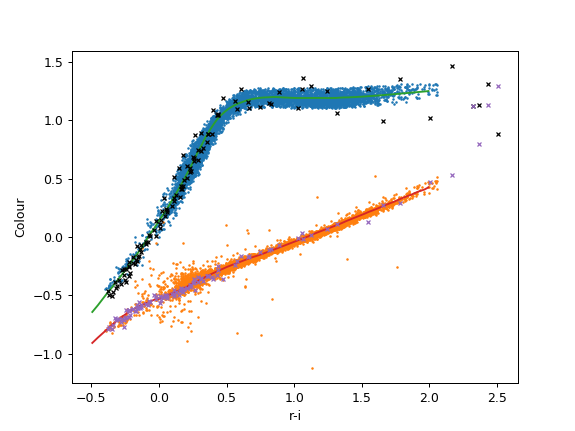

Text(0.5, 0, 'r-i')

In [156]:
compare = np.array([['r-i','g-r'],['r-i','i-z']])
colours = Make_colours(dat.iloc[clips],tonry,compare,Extinction = ex)
plt.figure()
plt.plot(colours['obs r-i'][0],colours['obs g-r'][0],'.',ms=2)
plt.plot(colours['obs r-i'][0],colours['obs i-z'][0]-.5,'.',ms=2)
plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2]-.5,'-')

plt.plot(test['r']-test['i'],test['g']-test['r'],'xk',ms=3)
plt.plot(test['r']-test['i'],test['i']-test['z']-.5,'x',ms=3)
plt.ylabel('Colour')
plt.xlabel('r-i')

In [137]:
def Spec_mags(Models,pbs,a_v=0):
    pbg, zpg = pbs['ps1g']
    pbr, zpr = pbs['ps1r']
    pbi, zpi = pbs['ps1i']
    pbz, zpz = pbs['ps1z']
    pbk, zpk = pbs['Kep']

    mg = []
    mr = []
    mi = []
    mz = []
    mk = []
    # construct mags
    ind = []
    red = {}
    for modelname in Models:
        model = Models[modelname]
        model = S.ArraySpectrum(model.wave, 
                                apply(fm07(model.wave.astype('double'),a_v),model.flux), 
                                name=modelname)
        mg += [source_synphot.passband.synphot(model, pbg,zpg)]
        mr += [source_synphot.passband.synphot(model, pbr,zpr)]
        mi += [source_synphot.passband.synphot(model, pbi,zpi)]
        mz += [source_synphot.passband.synphot(model, pbz,zpz)]
        mk += [source_synphot.passband.synphot(model, pbk,zpk)]

    mg = np.array(mg)
    mr = np.array(mr)
    mi = np.array(mi)
    mz = np.array(mz)
    mk = np.array(mk)
    good = np.isfinite(mg) & np.isfinite(mr) & np.isfinite(mi) & np.isfinite(mz) & np.isfinite(mk)
    d = {'g':mg[good], 'r':mr[good],'i':mi[good],'z':mz[good],'k':mk[good]}
    return d

In [190]:
coords = SkyCoord(dat['RAJ2000'].values*u.deg, dat['DecJ2000'].values*u.deg,distance=500.*u.pc, frame='icrs')
bayestar = BayestarQuery(max_samples=1)

red = bayestar(coords, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 28.862 s
  pix_info:   0.716 s
   samples:   8.082 s
      best:   8.748 s
       nan:   0.341 s
      sort:  10.752 s
       idx:   0.223 s


In [195]:
np.nanmax(red)

0.14999999

In [276]:
mx = colours['mod g-r']
my = colours['mod r-i']
oy = colours['obs r-i'][0,:] + (red*2.617 - red*1.971)*-1
ye = colours['obs r-i'][1,:] + (red*2.617 - red*1.971)*-1
ox = colours['obs g-r'][0,:] + (red*3.518 - red*2.617)*-1
ind = (ox > 0.5) & (ox<0.9)
oy = oy[ind]
ox=ox[ind]
ye = ye[ind]
thing = interpolate.interp1d(mx,my)
yy = thing(ox)

<IPython.core.display.Javascript object>


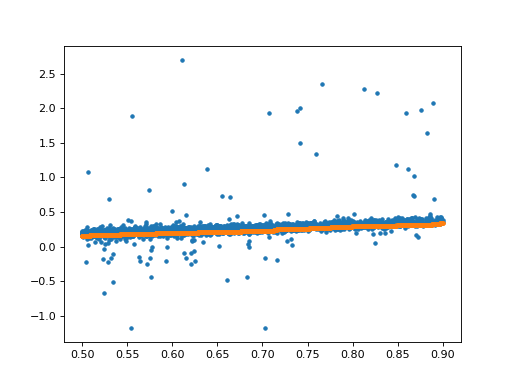

In [277]:
plt.figure()
plt.plot(ox,oy,'.')
plt.plot(ox,yy,'.')


In [198]:
oy.shape

(3985,)

0.0026990672037958564


<IPython.core.display.Javascript object>


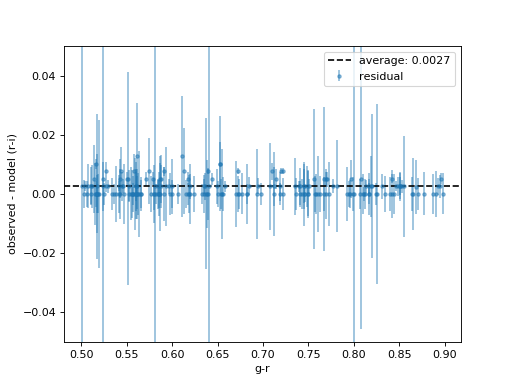

''

In [317]:
mx = colours['mod g-r']
my = colours['mod g-r']
oy = colours['obs g-r'][0,:] + (red*2.617 - red*1.971)*-1
ye = colours['obs g-r'][1,:] + (red*2.617 - red*1.971)*-1
ox = colours['obs g-r'][0,:] + (red*3.518 - red*2.617)*-1
ind = (ox > 0.5) & (ox<0.9)
oy = oy[ind]
ox=ox[ind]
ye = ye[ind]
thing = interpolate.interp1d(mx,my,bounds_error=False,fill_value='extrapolate')
yy = thing(ox)

med = np.nanmedian(oy-yy)
med = np.average(oy-yy,weights=1/ye)
yyy = oy-yy
ind = (abs(yyy-med) < .1) & (abs(yyy-med) < 5*ye)
yyy = yyy[ind]
xx = ox[ind]
yye = ye[ind]
med = np.average(yyy,weights=1/yye)
print(med)
plt.figure()
plt.errorbar(xx,yyy,yerr=yye,fmt='.',label='residual',alpha=0.5)
plt.axhline(med,ls='--',color='k',label='average: {}'.format(np.round(med,4)))
#plt.plot(ox,yy+.05,'.')
plt.ylim(-.05,.05)
plt.xlabel('g-r')
plt.ylabel('$\Delta$(g-r)')
plt.legend()
plt.savefig('g-r_residuals.png')
;

In [376]:
from astropy.modeling import models, fitting
import scipy.optimize

In [377]:
model = models.Linear1D()
fitter = fitting.LinearLSQFitter()

0.03345272613799998


<IPython.core.display.Javascript object>


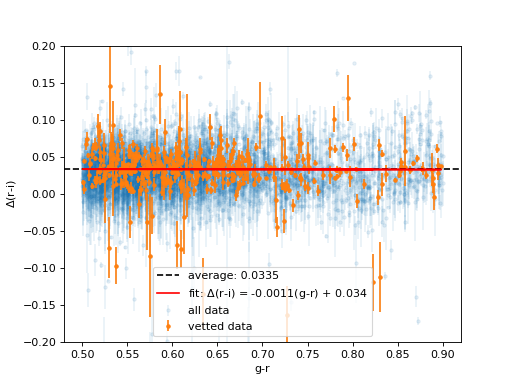

''

In [456]:
mx = colours['mod g-r']
my = colours['mod r-i']
oy = colours['obs r-i'][0,:] + (red*2.617 - red*1.971)*-1
ye = colours['obs r-i'][1,:] + (red*2.617 - red*1.971)*-1
ox = colours['obs g-r'][0,:] + (red*3.518 - red*2.617)*-1

gr = colours['obs g-r'][0,:] + (red*3.518 - red*2.617)*-1

ind = (gr > 0.5) & (gr<0.9)
oy = oy[ind]
ox=ox[ind]
ye = ye[ind]
thing = interpolate.interp1d(mx,my,bounds_error=False,fill_value='extrapolate')
yy = thing(ox)

med = np.nanmedian(oy-yy)
med = np.average(oy-yy,weights=1/ye)
yyy = oy-yy

ind = (abs(yyy-med) < 1) & (abs(yyy-med) < 6*ye) & (ye < .1)
yyy = yyy[ind]
xx = ox[ind]
yye = ye[ind]
best_fit = fitter(model, xx, yyy, weights=1.0/yye**2)
med = np.average(yyy,weights=1/yye)
print(med)
plt.figure()
plt.errorbar(ox,oy-yy,ye,fmt='.',label='all data',alpha=0.1,zorder=-100)
plt.errorbar(xx,yyy,yerr=yye,fmt='.',label='vetted data',alpha=1,zorder=-1)
plt.axhline(med,ls='--',color='k',label='average: {}'.format(np.round(med,4)),zorder=0)
plt.plot(xx, best_fit(xx), 'r-',zorder=1,label=r'fit: $\Delta$(r-i) = {}(g-r) + {}'.format(np.round(best_fit.slope.value,4),np.round(best_fit.intercept.value,4)))
#plt.plot(ox,yy+.05,'.')
plt.ylim(-.2,.2)
plt.xlabel('g-r')
plt.ylabel('$\Delta$(r-i)')
plt.legend()
plt.savefig('r-i_residuals.png')
;

In [383]:
best_fit

<Linear1D(slope=0.00394349, intercept=0.02878708)>

0.03154752681271399

0.004295765855158257


<IPython.core.display.Javascript object>


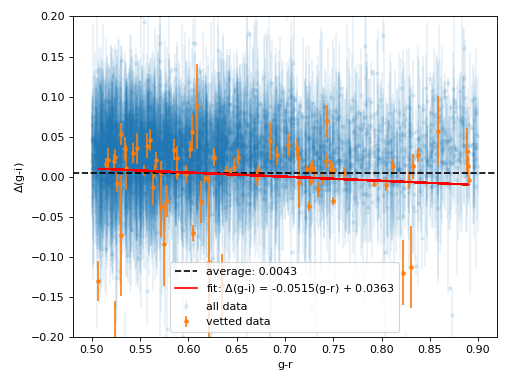

''

In [457]:
mx = colours['mod g-r']
my = colours['mod g-i']
oy = colours['obs g-i'][0,:] #+ (red*3.518 - red*1.971)*-1
ye = colours['obs g-i'][1,:] + (red*3.518 - red*1.971)*-1
ox = colours['obs g-r'][0,:] #+ (red*3.518 - red*2.617)*-1

gr = colours['obs g-r'][0,:] #+ (red*3.518 - red*2.617)*-1

ind = (gr > 0.5) & (gr<0.9)
oy = oy[ind]
ox=ox[ind]
ye = ye[ind]
thing = interpolate.interp1d(mx,my,bounds_error=False,fill_value='extrapolate')
yy = thing(ox)

med = np.nanmedian(oy-yy)
med = np.average(oy-yy,weights=1/ye)
yyy = oy-yy
ind = (abs(yyy-med) < 1) & (abs(yyy-med) < 6*ye) & (ye < .1)
yyy = yyy[ind]
xx = ox[ind]
yye = ye[ind]
best_fit = fitter(model, xx, yyy, weights=1.0/yye**2)
med = np.average(yyy,weights=1/yye)
print(med)
plt.figure()
plt.errorbar(ox,oy-yy,ye,fmt='.',label='all data',alpha=0.1,zorder=-100)
plt.errorbar(xx,yyy,yerr=yye,fmt='.',label='vetted data',alpha=1,zorder=-1)
plt.axhline(med,ls='--',color='k',label='average: {}'.format(np.round(med,4)),zorder=0)
plt.plot(xx, best_fit(xx), 'r-',zorder=1,label='fit: $\Delta$(g-i) = {}(g-r) + {}'.format(np.round(best_fit.slope.value,4),np.round(best_fit.intercept.value,4)))
#plt.plot(ox,yy+.05,'.')
plt.ylim(-.2,.2) 
#plt.xlim(0.6,1.4)
plt.xlabel('g-r')
plt.ylabel('$\Delta$(g-i)')
plt.legend()
plt.tight_layout()
plt.savefig('g-i_residuals.png')
;

In [404]:
best_fit

<Linear1D(slope=-0.05146573, intercept=0.0362701)>

-0.0234720194135671


<IPython.core.display.Javascript object>


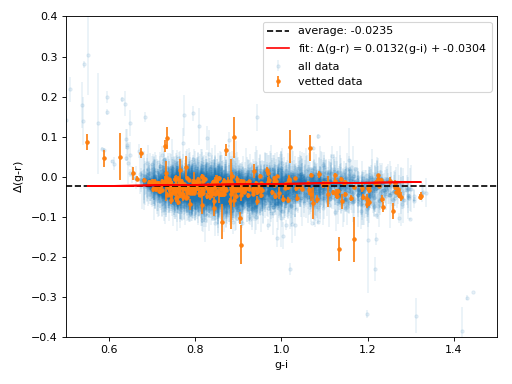

''

In [453]:
mx = colours['mod g-i']
my = colours['mod g-r']
oy = colours['obs g-r'][0,:] #+ (red*3.518 - red*2.617)*-1
ye = colours['obs g-r'][1,:] + (red*3.518 - red*2.617)*-1
ox = colours['obs g-i'][0,:] #+ (red*2.617 - red*1.971)*-1

gr = colours['obs g-r'][0,:] #+ (red*3.518 - red*2.617)*-1

ind = (gr > 0.5) & (gr<0.9)
oy = oy[ind]
ox=ox[ind]
ye = ye[ind]
thing = interpolate.interp1d(mx,my,bounds_error=False,fill_value='extrapolate')
yy = thing(ox)

med = np.nanmedian(oy-yy)
med = np.average(oy-yy,weights=1/ye)
yyy = oy-yy
ind = (abs(yyy-med) < .2) & (abs(yyy-med) < 6*ye) & (ye < .1)
yyy = yyy[ind]
xx = ox[ind]
yye = ye[ind]
best_fit = fitter(model, xx, yyy, weights=1.0/yye**2)
med = np.average(yyy,weights=1/yye)
print(med)
plt.figure()
plt.errorbar(ox,oy-yy,ye,fmt='.',label='all data',alpha=0.1,zorder=-100)
plt.errorbar(xx,yyy,yerr=yye,fmt='.',label='vetted data',alpha=1,zorder=-1)
plt.axhline(med,ls='--',color='k',label='average: {}'.format(np.round(med,4)),zorder=0)
plt.plot(xx, best_fit(xx), 'r-',zorder=1,label='fit: $\Delta$(g-r) = {}(g-i) + {}'.format(np.round(best_fit.slope.value,4),np.round(best_fit.intercept.value,4)))
#plt.plot(ox,yy+.05,'.')
plt.ylim(-.4,.4)
plt.xlim(.5,1.5)
plt.xlabel('g-i')
plt.ylabel('$\Delta$(g-r)')
plt.legend()
plt.tight_layout()
plt.savefig('g-r_residuals.png')
;

In [420]:
best_fit.intercept

Parameter('intercept', value=-0.0484398808976133)

0.0


<IPython.core.display.Javascript object>


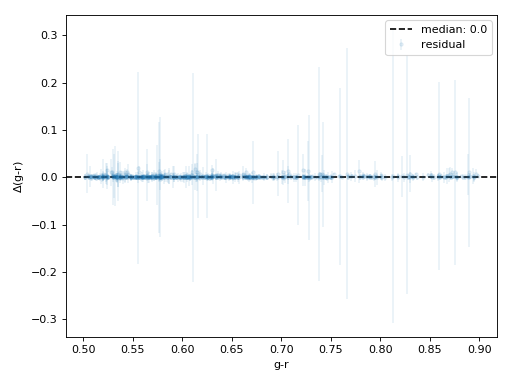

''

In [313]:
mx = colours['mod g-r']
my = colours['mod g-r']
oy = colours['obs g-r'][0,:] + (red*2.617 - red*1.971)*-1
ye = colours['obs g-r'][1,:] + (red*2.617 - red*1.971)*-1
ox = colours['obs g-r'][0,:] + (red*3.518 - red*2.617)*-1

gr = colours['obs g-r'][0,:] + (red*3.518 - red*2.617)*-1

ind = (gr > 0.5) & (gr<0.9)
oy = oy[ind]
ox=ox[ind]
ye = ye[ind]
thing = interpolate.interp1d(mx,my)
yy = thing(ox)

med = np.nanmedian(oy-yy)
yyy = oy-yy
ind = (abs(yyy-med) < .1) & (abs(yyy-med) < 5*ye)
yyy = yyy[ind]
xx = ox[ind]
yye = ye[ind]
med = np.nanmedian(yyy)
print(med)
plt.figure()
plt.errorbar(xx,yyy,yerr=yye,fmt='.',label='residual',alpha=0.1)
plt.axhline(med,ls='--',color='k',label='median: {}'.format(np.round(med,4)))
#plt.plot(ox,yy+.05,'.')
#plt.ylim(-.2,.2)
plt.xlabel('g-r')
plt.ylabel('$\Delta$(g-r)')
plt.legend()
plt.tight_layout()
plt.savefig('g-r_residuals.png')
;

In [236]:
ygr = yyy

In [245]:
ygr - ygi

ValueError: operands could not be broadcast together with shapes (3443,) (3409,) 

In [248]:
0.0076499879360198975 -0.0076499879360198975

0.0

In [201]:
from astropy.modeling import models, fitting

In [202]:
# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, ox, oy-yy)#, weights=1.0/ye)


In [203]:
fitted_line(ox)

array([0.03483811, 0.04814696, 0.02364446, ..., 0.02694305, 0.03387446,
       0.04452057])

In [206]:
def line_fit(var,x,y,yerr):
    fit = var[0]*x +var[1]
    res = abs(fit - y) * abs(1/yerr)
    return np.nansum(res)


In [207]:
var = minimize(line_fit,[0,0],args=(ox, oy-yy,ye))

In [208]:
var.x[0]

-0.07741990565135334

<IPython.core.display.Javascript object>


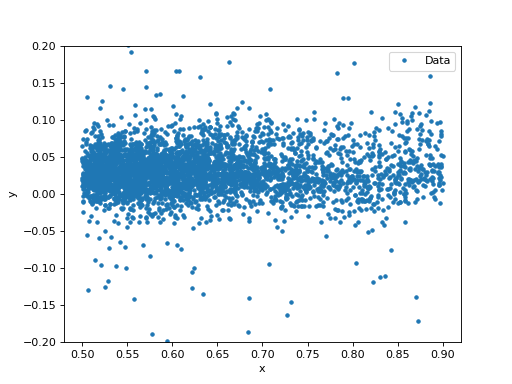

(-0.2, 0.2)

In [212]:
plt.figure()
plt.errorbar(ox, oy-yy, fmt='.', label='Data')
#plt.plot(x, line_orig(ox), 'b-', label='Simulation Model')
#plt.plot(ox, fitted_line(ox), 'k.', label='Fitted Model')
#plt.plot(ox, var.x[0]*(oy-yy) + var.x[1], 'k.', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim(-.2,.2)

In [12]:
import copy
def Get_lcs(X,Y,Params,Colours):
    keys = np.array(list(Colours.keys()))

    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]

    x_interp = np.arange(np.nanmin(x),0.9,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])

    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 

    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == 'k': ob_x[0,:] += Params['kzp']
    if c2 == 'k': ob_x[0,:] -= Params['kzp']


    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == 'k': ob_y[0,:] += Params['kzp']
    if c4 == 'k': ob_y[0,:] -= Params['kzp']
    return ob_x, ob_y, locus

def Cut_data(K,Colours,Compare,Plot=False):
    Params = {}
    Params['Ag'] = K[0]
    Params['Ar'] = K[1]
    Params['Ai'] = K[2]
    Params['Az'] = K[3]
    keys = np.array(list(Colours.keys()))
    c_cut = copy.deepcopy(Colours)
    for X,Y in Compare:
        dist = Dist_tensor(X,Y,Params,Colours,True)
        if len(dist) > 0:

            ob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours)
            ob_x2, ob_y2, locus = Get_lcs(X,Y,Params,Colours)
            if X == 'g-r':
                ind = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= -0.5))[0]
            elif X == 'r-i':
                ind = np.where((ob_x[0,:] <= .5) & (ob_x[0,:] >= -0.5))[0]
            ob_x = ob_x[:,ind]
            ob_y = ob_y[:,ind]


            bad = []
            for i in range(len(dist)):
                #print(dist[i],ob_y[1,i])
                if abs(dist[i]) > 1:
                    #print(dist,ob_y[0,i])
                    bad += [i]
                if abs(dist[i]) > 6*ob_y[1,i]:

                    bad += [i]
            if Plot:
                plt.figure()
                plt.errorbar(ob_x2[0,:],ob_y2[0,:],yerr = ob_y2[1,:],fmt='.')
                plt.errorbar(locus[0,:],locus[1,:])
                plt.errorbar(ob_x[0,bad],ob_y[0,bad],yerr = ob_y[1,bad],fmt='.')
                plt.errorbar(ob_x2[0,ind[bad]],ob_y2[0,ind[bad]],yerr = ob_y2[1,ind[bad]],fmt='.')
                #plt.xlim(.5,0.9)
            
            for key in keys:
                if 'obs' in key:
                    #print(dist[bad],6*c_cut[key][1, main_ind[bad]])
                    c_cut[key][:, ind[bad]] = np.nan
                    #print('killed ', key)
            #print(colours[keys[xind][0]][:, main_ind[bad]])
    return c_cut

# Dust maps

In [143]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u



In [149]:
coords = SkyCoord(287.83*u.deg, -23.36*u.deg,distance=500.*u.pc, frame='icrs')
bayestar = BayestarQuery(max_samples=1)

red = bayestar(coords, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 28.952 s
  pix_info:   0.843 s
   samples:   8.686 s
      best:   8.329 s
       nan:   0.337 s
      sort:  10.567 s
       idx:   0.190 s


In [ ]:
bayestar

In [150]:
red

0.16

In [ ]:
Sky